# Import library and Data Analysis






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization, Input
from keras.optimizers import Adam
from keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.experimental import preprocessing
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import mixed_precision
mixed_precision.set_global_policy('float32')


print(tf.__version__)

2.15.0


Loading dataset

In [ ]:
# Define dataset paths
dataset = {
            "train_data" : "/content/drive/MyDrive/Thesis /data_thesis/train",
             "valid_data" : "/content/drive/MyDrive/Thesis /data_thesis/valid",
             "test_data" : "/content/drive/MyDrive/Thesis /data_thesis/test"
}


all_data = []
for path in dataset.values():
    data = {"imgpath": [] , "labels": [] }
    category = os.listdir(path)

    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)


    all_data.append(data.copy())
    data.clear()



train_df = pd.DataFrame(all_data[0] , index=range(len(all_data[0]['imgpath'])))
valid_df = pd.DataFrame(all_data[1] , index=range(len(all_data[1]['imgpath'])))
test_df = pd.DataFrame(all_data[2] , index=range(len(all_data[2]['imgpath'])))


# #Convert labels to numbers
lb = LabelEncoder()
train_df['encoded_labels'] = lb.fit_transform(train_df['labels'])
valid_df['encoded_labels'] = lb.fit_transform(valid_df['labels'])
test_df['encoded_labels'] = lb.fit_transform(test_df['labels'])

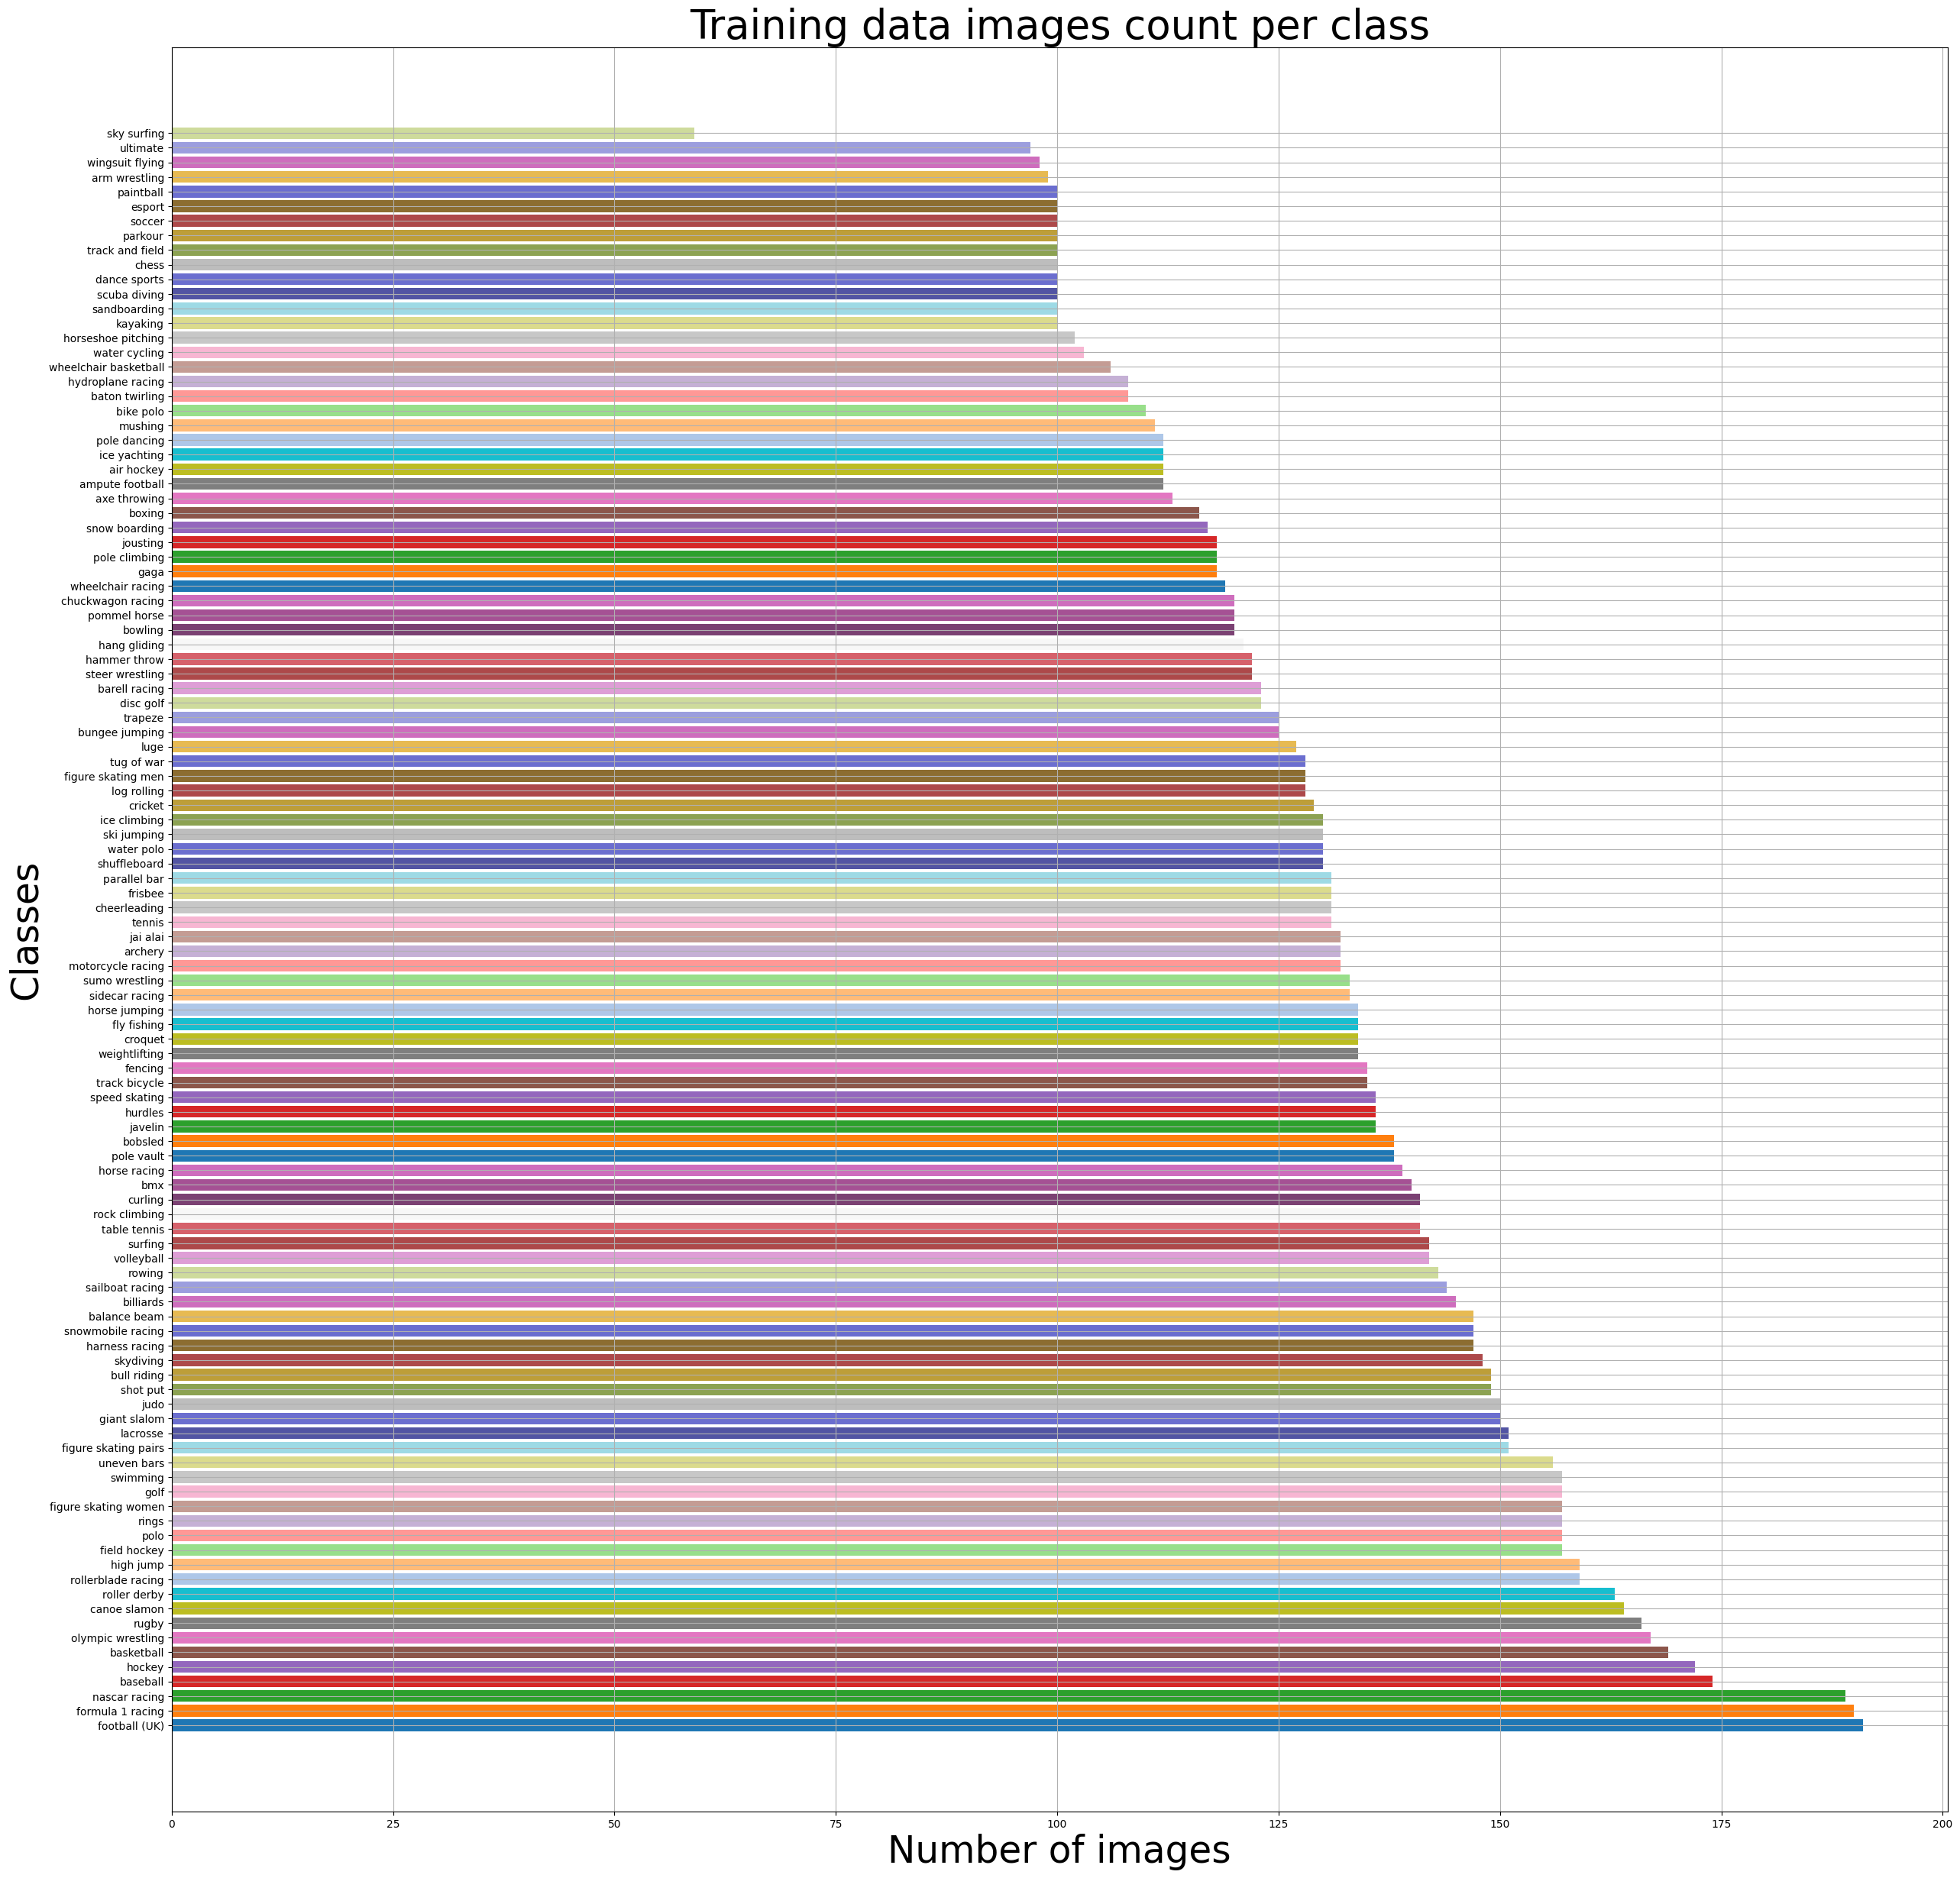

In [ ]:
train  = train_df["labels"].value_counts()
label = train.tolist()
index = train.index.tolist()

colors = [
    "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
    "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
    "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
    "#5254a3", "#6b6ecf", "#bdbdbd", "#8ca252", "#bd9e39",
    "#ad494a", "#8c6d31", "#6b6ecf", "#e7ba52", "#ce6dbd",
    "#9c9ede", "#cedb9c", "#de9ed6", "#ad494a", "#d6616b",
    "#f7f7f7", "#7b4173", "#a55194", "#ce6dbd"
]



plt.figure(figsize=(30,30))
plt.title("Training data images count per class",fontsize=38)
plt.xlabel('Number of images', fontsize=35)
plt.ylabel('Classes', fontsize=35)
plt.barh(index,label, color=colors)
plt.grid(True)
plt.show()


In [ ]:
train_df.sample(n=15, random_state=1)

imgpath              labels  \
12140  /content/drive/MyDrive/Thesis /data_thesis/tra...          basketball   
3881   /content/drive/MyDrive/Thesis /data_thesis/tra...  rollerblade racing   
7655   /content/drive/MyDrive/Thesis /data_thesis/tra...       horse jumping   
7860   /content/drive/MyDrive/Thesis /data_thesis/tra...              hockey   
8450   /content/drive/MyDrive/Thesis /data_thesis/tra...        hammer throw   
13801  /content/drive/MyDrive/Thesis /data_thesis/tra...        dance sports   
1175   /content/drive/MyDrive/Thesis /data_thesis/tra...              tennis   
12605  /content/drive/MyDrive/Thesis /data_thesis/tra...       arm wrestling   
3526   /content/drive/MyDrive/Thesis /data_thesis/tra...            shot put   
1225   /content/drive/MyDrive/Thesis /data_thesis/tra...              tennis   
2578   /content/drive/MyDrive/Thesis /data_thesis/tra...           skydiving   
14214  /content/drive/MyDrive/Thesis /data_thesis/tra...              esport   
4288   /content/drive/MyDrive/Thesis /data_thesis/tra...               rings   
3610   /content/drive/MyDrive/Thesis /data_thesis/tra...            shot put   
9398   /content/drive/MyDrive/Thesis /data_thesis/tra...   chuckwagon racing   

       encoded_labels  
12140               8  
3881               75  
7655               45  
7860               44  
8450               40  
13801              25  
1175               96  
12605               3  
3526               81  
1225               96  
2578               86  
14214              27  
4288               72  
3610               81  
9398               21

In [ ]:
print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                             imgpath         labels
0  /content/drive/MyDrive/Thesis /data_thesis/tra...  weightlifting
1  /content/drive/MyDrive/Thesis /data_thesis/tra...  weightlifting
2  /content/drive/MyDrive/Thesis /data_thesis/tra...  weightlifting
3  /content/drive/MyDrive/Thesis /data_thesis/tra...  weightlifting
4  /content/drive/MyDrive/Thesis /data_thesis/tra...  weightlifting
(14493, 3)
--------Validation----------
                                             imgpath      labels
0  /content/drive/MyDrive/Thesis /data_thesis/val...  tug of war
1  /content/drive/MyDrive/Thesis /data_thesis/val...  tug of war
2  /content/drive/MyDrive/Thesis /data_thesis/val...  tug of war
3  /content/drive/MyDrive/Thesis /data_thesis/val...  tug of war
4  /content/drive/MyDrive/Thesis /data_thesis/val...  tug of war
(550, 3)
----------Test--------------
                                             imgpath           labels
0  /content/drive/MyDrive

Show sample from data

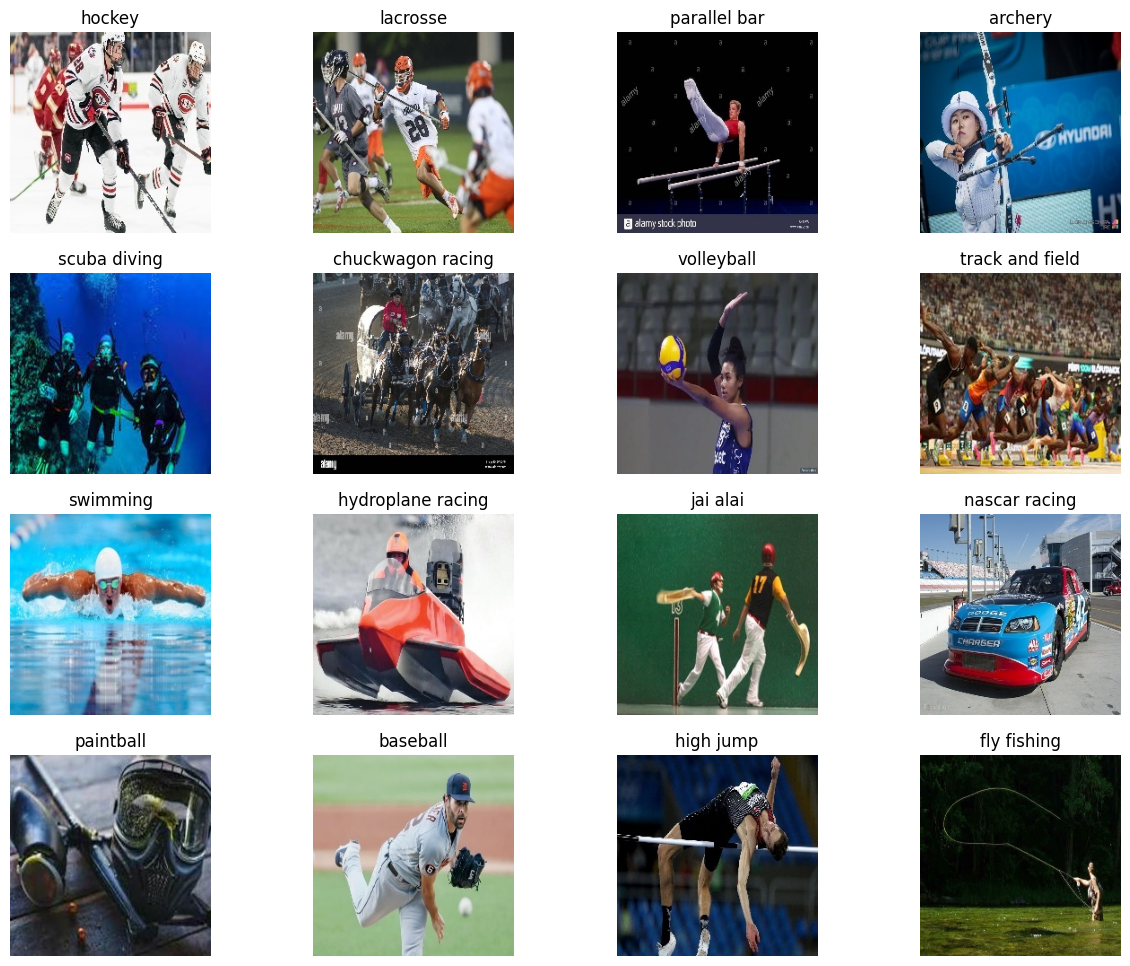

In [ ]:
plt.figure(figsize=(15,12))
for i, row in valid_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

#EfficientNet B0

In [ ]:
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)


generator = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14492 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.


In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [ ]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')



inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(350)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_5 (Dense)             (None, 350)               448350    
                                                                 
 activation_190 (Activation  (None, 350)               0         
 )                                                               
                                                           

Training: Transfer learning

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save('/content/drive/MyDrive/Thesis /data_thesis/EfficientNetB0.h5')

Epoch 1/50
1450/1450 [==============================] - 63s 38ms/step - loss: 1.8866 - accuracy: 0.5600 - val_loss: 0.5629 - val_accuracy: 0.8509 - lr: 5.0000e-04
Epoch 2/50
1450/1450 [==============================] - 54s 38ms/step - loss: 0.8540 - accuracy: 0.7782 - val_loss: 0.4557 - val_accuracy: 0.8764 - lr: 5.0000e-04
Epoch 3/50
1450/1450 [==============================] - 54s 38ms/step - loss: 0.6978 - accuracy: 0.8178 - val_loss: 0.6569 - val_accuracy: 0.8236 - lr: 5.0000e-04
Epoch 4/50
1450/1450 [==============================] - 53s 37ms/step - loss: 0.6281 - accuracy: 0.8326 - val_loss: 0.4933 - val_accuracy: 0.8727 - lr: 5.0000e-04
Epoch 5/50
1450/1450 [==============================] - 55s 38ms/step - loss: 0.5033 - accuracy: 0.8643 - val_loss: 0.2505 - val_accuracy: 0.9400 - lr: 1.0000e-04
Epoch 6/50
1450/1450 [==============================] - 55s 38ms/step - loss: 0.4621 - accuracy: 0.8748 - val_loss: 0.2543 - val_accuracy: 0.9327 - lr: 1.0000e-04
Epoch 7/50
1450/1450 [

Display model performance

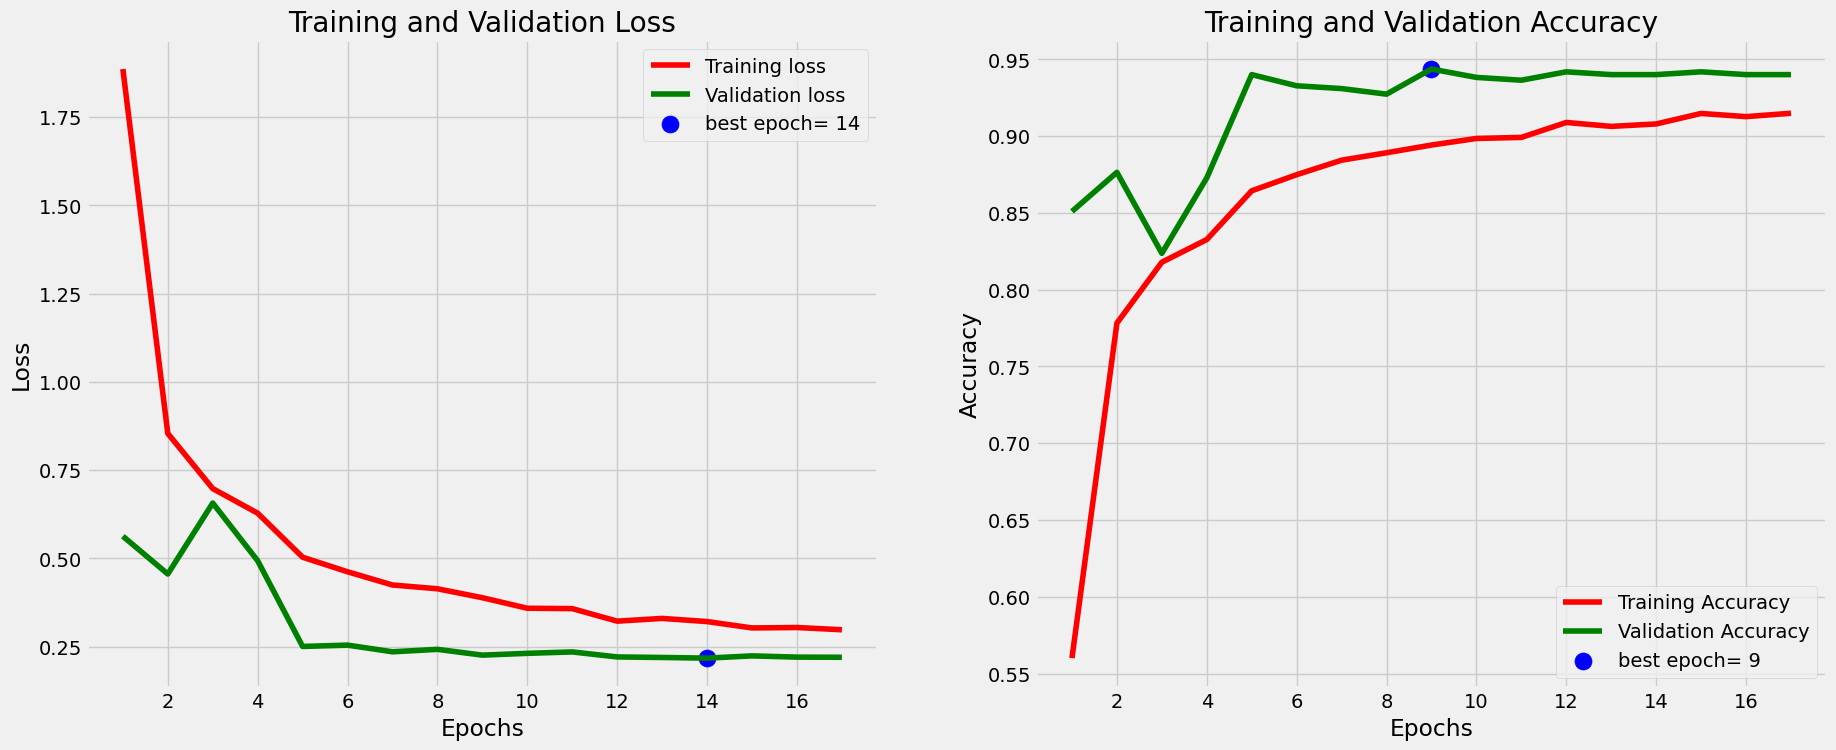

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()


Model Evaluate

In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.12516
Test Accuracy: 96.55%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

55/55 [==============================] - 3s 35ms/step
F1 Score: 0.9641617473435655
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       0.83      1.00      0.91         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       0.83      1.00      0.91         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00  

#VGG16

In [ ]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.vgg16.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_vgg16 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_vgg16 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_vgg16 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 14492 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.


In [ ]:
from keras.applications import VGG16
# Load and modify the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
from keras.layers import GlobalAveragePooling2D, RandomFlip, RandomRotation, RandomZoom, RandomContrast
num_classes = len(set(train_images_vgg16.classes))
# Define data augmentation
data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1),
  RandomZoom(0.1),
  RandomContrast(0.1),
], name='data_augmentation')

# Modify the model
inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)  # Set training=False for batch norm layers
x = GlobalAveragePooling2D()(x)
x = Dense(350, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 350)               179550    
                                                                 
 batch_normalization (Batch  (None, 350)               1400  

Training: Transfer learning

In [ ]:
# Train the model
history_vgg16 = model.fit(
    train_images_vgg16,
    steps_per_epoch=len(train_images_vgg16),
    validation_data=val_images_vgg16,
    validation_steps=len(val_images_vgg16),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Thesis/data_thesis/vgg16.h5')

Epoch 1/50
1450/1450 [==============================] - 8830s 6s/step - loss: 2.8638 - accuracy: 0.3401 - val_loss: 1.5522 - val_accuracy: 0.6255 - lr: 5.0000e-04
Epoch 2/50
1450/1450 [==============================] - 86s 59ms/step - loss: 1.7389 - accuracy: 0.5540 - val_loss: 1.2949 - val_accuracy: 0.7036 - lr: 5.0000e-04
Epoch 3/50
1450/1450 [==============================] - 85s 59ms/step - loss: 1.4873 - accuracy: 0.6111 - val_loss: 1.0594 - val_accuracy: 0.7400 - lr: 5.0000e-04
Epoch 4/50
1450/1450 [==============================] - 85s 59ms/step - loss: 1.3715 - accuracy: 0.6375 - val_loss: 1.0338 - val_accuracy: 0.7200 - lr: 5.0000e-04
Epoch 5/50
1450/1450 [==============================] - 85s 59ms/step - loss: 1.2798 - accuracy: 0.6582 - val_loss: 1.1253 - val_accuracy: 0.7255 - lr: 5.0000e-04
Epoch 6/50
1450/1450 [==============================] - 85s 59ms/step - loss: 1.2352 - accuracy: 0.6644 - val_loss: 1.1272 - val_accuracy: 0.7509 - lr: 5.0000e-04
Epoch 7/50
1450/1450 [

Display model performance

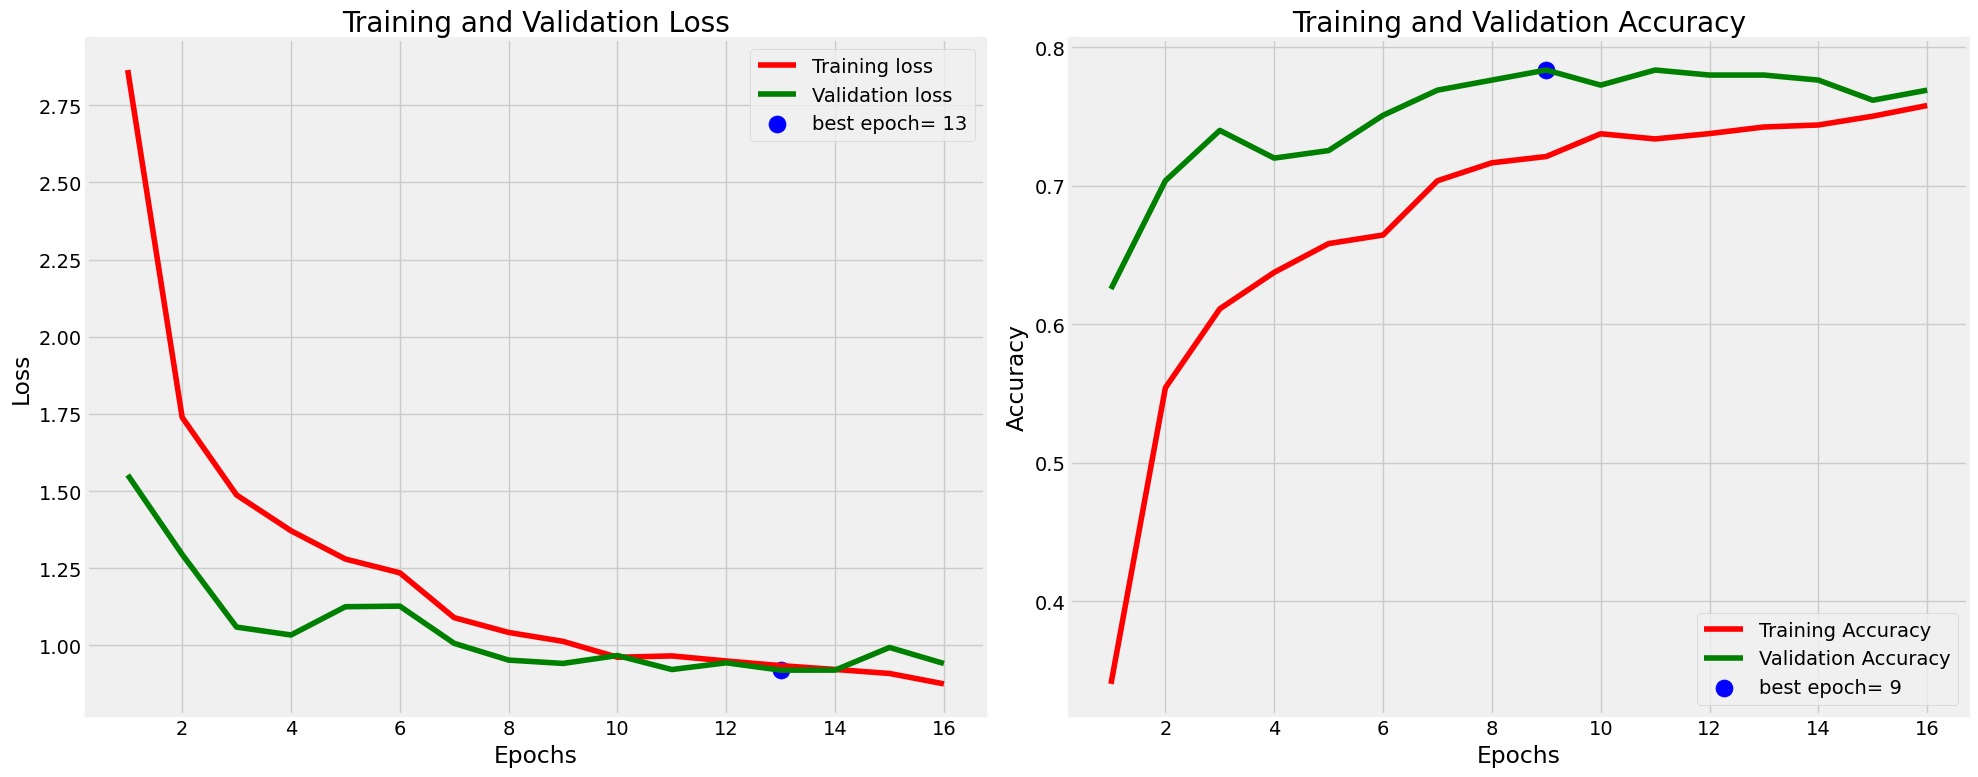

In [ ]:
# Corrected variable assignments
tr_acc = history_vgg16.history['accuracy']
tr_loss = history_vgg16.history['loss']
val_acc = history_vgg16.history['val_accuracy']
val_loss = history_vgg16.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

model evaluate

In [ ]:
results = model.evaluate(test_images_vgg16, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.75262
Test Accuracy: 84.00%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images_vgg16.classes
y_pred = np.argmax(model.predict(test_images_vgg16), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_vgg16.class_indices.keys()))

55/55 [==============================] - 3s 56ms/step
F1 Score: 0.8317000676091584
                       precision    recall  f1-score   support

           air hockey       0.83      1.00      0.91         5
      ampute football       1.00      1.00      1.00         5
              archery       0.50      0.80      0.62         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       0.71      1.00      0.83         5
         balance beam       0.62      1.00      0.77         5
        barell racing       0.83      1.00      0.91         5
             baseball       1.00      0.60      0.75         5
           basketball       0.62      1.00      0.77         5
       baton twirling       0.80      0.80      0.80         5
            bike polo       0.56      1.00      0.71         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.40      0.57         5
              bobsled       0.75  

#ResNet50

In [ ]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.resnet50.preprocess_input)
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_resnet50 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_resnet50 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_resnet50 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14492 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.


In [ ]:
from keras.applications import ResNet50
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
num_classes = len(set(train_images_resnet50.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.1),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Load pre-trained ResNet50 model
pretrained_model_resnet50 = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_resnet50.layers:
    layer.trainable = False

inputs_resnet50 = layers.Input(shape=(224, 224, 3), name='inputLayer')
x_resnet50 = augment(inputs_resnet50)
pretrain_out_resnet50 = pretrained_model_resnet50(x_resnet50, training=False)
x_resnet50 = layers.Dense(350, activation="relu")(pretrain_out_resnet50)
x_resnet50 = layers.BatchNormalization()(x_resnet50)
x_resnet50 = layers.Dropout(0.25)(x_resnet50)
x_resnet50 = layers.Dense(num_classes, activation='softmax', dtype=tf.float32, name='activationLayer')(x_resnet50)

model_resnet50 = Model(inputs=inputs_resnet50, outputs=x_resnet50)

model_resnet50.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model_resnet50.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 350)               717150    
                                                                 
 batch_normalization_1 (Bat  (None, 350)               1400      
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 350)               0   

Transfer learning

In [ ]:
history_resnet50 = model_resnet50.fit(
    train_images_resnet50,
    steps_per_epoch=len(train_images_resnet50),
    validation_data=val_images_resnet50,
    validation_steps=len(val_images_resnet50),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_resnet50.save_weights('/content/drive/MyDrive/Thesis /data_thesis/Resnet50.h5')

Epoch 1/50
1450/1450 [==============================] - 71s 45ms/step - loss: 2.3755 - accuracy: 0.4501 - val_loss: 1.0156 - val_accuracy: 0.7000 - lr: 5.0000e-04
Epoch 2/50
1450/1450 [==============================] - 64s 44ms/step - loss: 1.3782 - accuracy: 0.6480 - val_loss: 0.6441 - val_accuracy: 0.7982 - lr: 5.0000e-04
Epoch 3/50
1450/1450 [==============================] - 63s 44ms/step - loss: 1.1475 - accuracy: 0.6980 - val_loss: 0.7271 - val_accuracy: 0.7764 - lr: 5.0000e-04
Epoch 4/50
1450/1450 [==============================] - 63s 44ms/step - loss: 1.0471 - accuracy: 0.7212 - val_loss: 0.5601 - val_accuracy: 0.8182 - lr: 5.0000e-04
Epoch 5/50
1450/1450 [==============================] - 63s 44ms/step - loss: 0.9603 - accuracy: 0.7394 - val_loss: 0.5981 - val_accuracy: 0.8073 - lr: 5.0000e-04
Epoch 6/50
1450/1450 [==============================] - 63s 44ms/step - loss: 0.8907 - accuracy: 0.7547 - val_loss: 0.6240 - val_accuracy: 0.8273 - lr: 5.0000e-04
Epoch 7/50
1450/1450 [

Display model performance

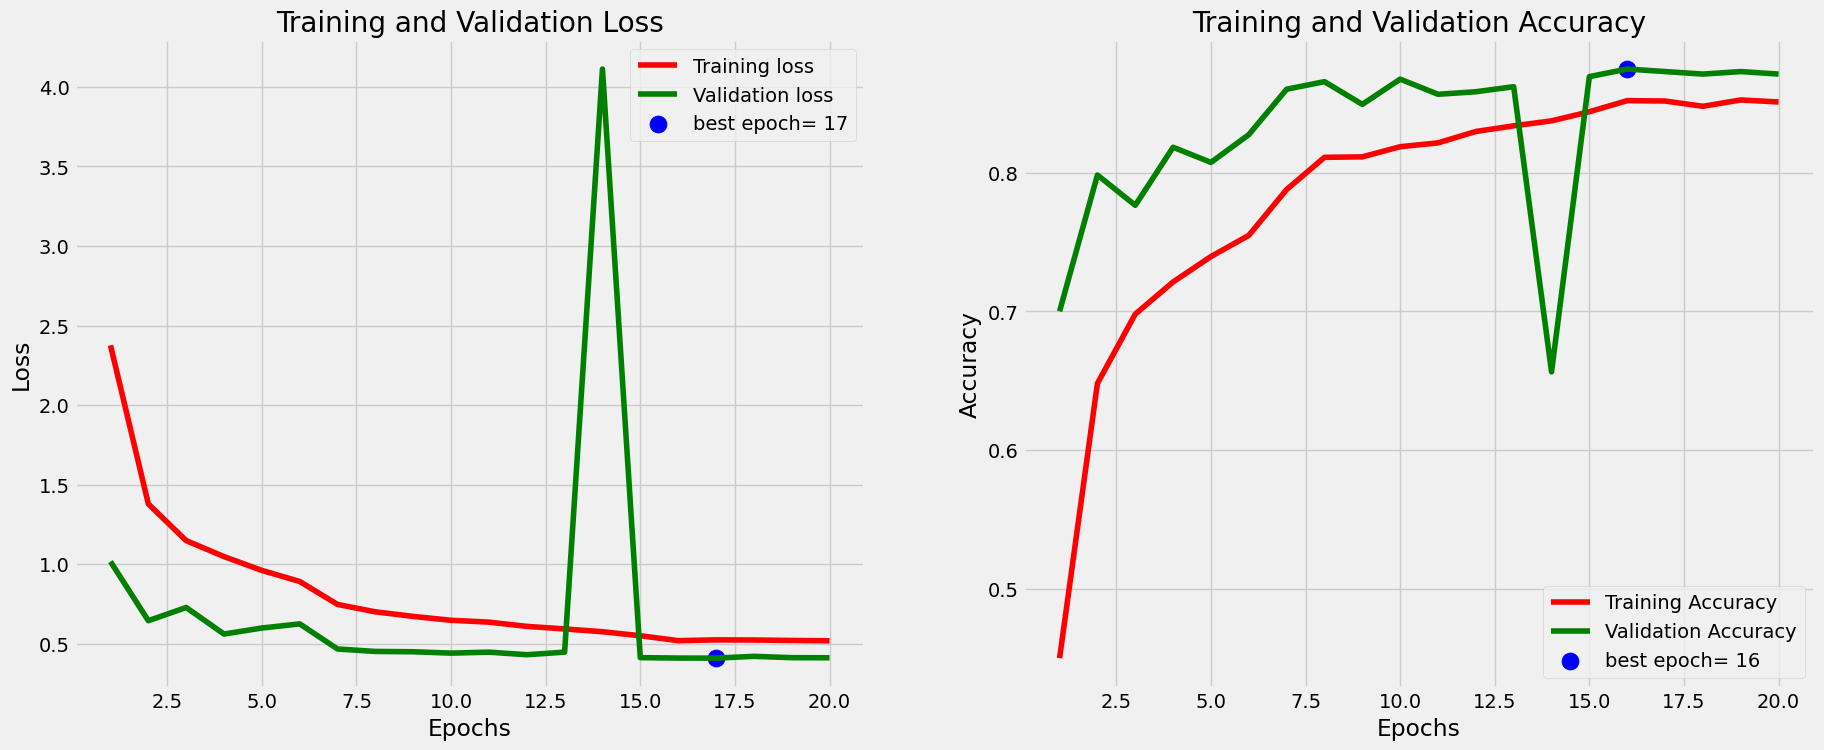

In [ ]:
# Define needed variables
tr_acc = history_resnet50.history['accuracy']
tr_loss = history_resnet50.history['loss']
val_acc = history_resnet50.history['val_accuracy']
val_loss = history_resnet50.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

  model evaluate

In [ ]:
results_resnet50 = model_resnet50.evaluate(test_images_resnet50, verbose=0)
print("ResNet50 Model - Test Loss: {:.5f}".format(results_resnet50[0]))
print("ResNet50 Model - Test Accuracy: {:.2f}%".format(results_resnet50[1] * 100))

ResNet50 Model - Test Loss: 0.32832
ResNet50 Model - Test Accuracy: 89.64%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images_resnet50.classes
y_pred = np.argmax(model_resnet50.predict(test_images_resnet50), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_resnet50.class_indices.keys()))

55/55 [==============================] - 3s 38ms/step
F1 Score: 0.8910035419126326
                       precision    recall  f1-score   support

           air hockey       0.83      1.00      0.91         5
      ampute football       1.00      1.00      1.00         5
              archery       0.50      1.00      0.67         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      0.80      0.89         5
         balance beam       0.71      1.00      0.83         5
        barell racing       0.83      1.00      0.91         5
             baseball       0.75      0.60      0.67         5
           basketball       0.80      0.80      0.80         5
       baton twirling       1.00      0.80      0.89         5
            bike polo       0.80      0.80      0.80         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.20      0.33         5
              bobsled       0.67  

#MobileNet V3 Large

In [ ]:
generator = ImageDataGenerator (preprocessing_function = tf.keras.applications.mobilenet_v3.preprocess_input)

BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

# Split the data into three categories.
train_images_mobilenet = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images_mobilenet = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_mobilenet = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 14492 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.


In [ ]:
from keras.applications import MobileNetV3Large

pretrained_model_mobilenetv3 = MobileNetV3Large(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of the pretrained neural network
for layer in pretrained_model_mobilenetv3.layers:
    layer.trainable = False

12683000/12683000 [==============================] - 1s 0us/step


In [ ]:
from keras.layers import GlobalAveragePooling2D
num_classes = len(set(train_images_mobilenet.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Building the model
inputs = layers.Input(shape=(224, 224, 3), name='inputLayer')
x = augment(inputs)
x = pretrained_model_mobilenetv3(x, training=False)


# Removed GlobalAveragePooling2D as the pretrained model already includes pooling
x = Dense(350, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=x)


# Compile the model
model.compile(optimizer=Adam(0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
print(model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 MobilenetV3large (Function  (None, 960)               2996352   
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 350)               336350    
                                                                 
 batch_normalization_2 (Bat  (None, 350)               1400      
 chNormalization)                                                
                                                           

Transfer learning

In [ ]:
# Training the model
history = model.fit(
    train_images_mobilenet,
    steps_per_epoch=len(train_images_mobilenet),
    validation_data=val_images_mobilenet,
    validation_steps=len(val_images_mobilenet),
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

# Save the model
model.save('/content/drive/MyDrive/Thesis/data_thesis/MobileNetV3Large.h5')


Epoch 1/50
1450/1450 [==============================] - 59s 37ms/step - loss: 2.0400 - accuracy: 0.5190 - val_loss: 0.6215 - val_accuracy: 0.8327 - lr: 5.0000e-04
Epoch 2/50
1450/1450 [==============================] - 51s 35ms/step - loss: 0.9300 - accuracy: 0.7519 - val_loss: 0.4400 - val_accuracy: 0.8836 - lr: 5.0000e-04
Epoch 3/50
1450/1450 [==============================] - 51s 35ms/step - loss: 0.7174 - accuracy: 0.7991 - val_loss: 0.4004 - val_accuracy: 0.8600 - lr: 5.0000e-04
Epoch 4/50
1450/1450 [==============================] - 51s 35ms/step - loss: 0.6363 - accuracy: 0.8213 - val_loss: 0.3582 - val_accuracy: 0.9000 - lr: 5.0000e-04
Epoch 5/50
1450/1450 [==============================] - 50s 35ms/step - loss: 0.5667 - accuracy: 0.8373 - val_loss: 0.3243 - val_accuracy: 0.9164 - lr: 5.0000e-04
Epoch 6/50
1450/1450 [==============================] - 51s 35ms/step - loss: 0.5318 - accuracy: 0.8476 - val_loss: 0.4113 - val_accuracy: 0.8909 - lr: 5.0000e-04
Epoch 7/50
1450/1450 [

Display model performance

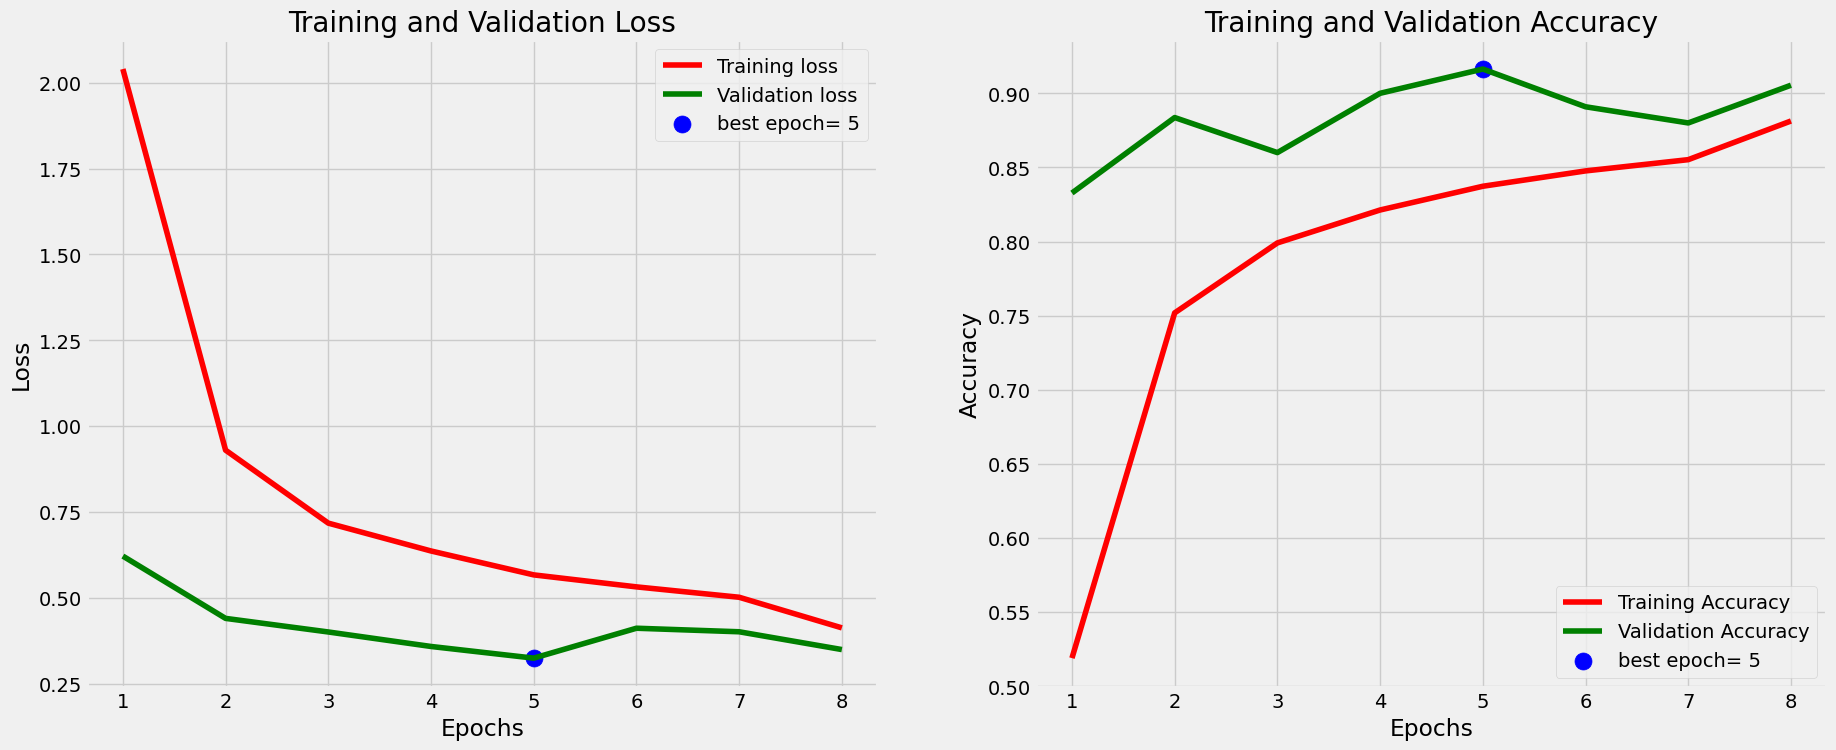

In [ ]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

model evaluate

In [ ]:
results_mobilenet = model.evaluate(test_images_mobilenet, verbose=0)
print("MobileNet Model - Test Loss: {:.5f}".format(results_mobilenet[0]))
print("MobileNet Model - Test Accuracy: {:.2f}%".format(results_mobilenet[1] * 100))

MobileNet Model - Test Loss: 0.22481
MobileNet Model - Test Accuracy: 93.82%


F1 Score / Recall / Precision


In [ ]:
y_true = test_images_mobilenet.classes
y_pred = np.argmax(model.predict(test_images_mobilenet), axis=1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_mobilenet.class_indices.keys()))

55/55 [==============================] - 3s 33ms/step
F1 Score: 0.9360740774377138
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      0.80      0.89         5
             baseball       1.00      1.00      1.00         5
           basketball       0.83      1.00      0.91         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00  

#Inception V3

In [ ]:
BATCH_SIZE = 10
IMAGE_SIZE = (224, 224)

generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)

val_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images_inception_v3 = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 14492 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.
Found 550 validated image filenames belonging to 110 classes.


In [ ]:
from keras.applications import InceptionV3
# Load the pretrained model
pretrained_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,  # We don't need the pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freeze the layers of the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

87910968/87910968 [==============================] - 4s 0us/step


In [ ]:
from keras.applications.inception_v3 import preprocess_input

#generator = ImageDataGenerator(preprocessing_function=preprocess_input)

num_classes = len(set(train_images_inception_v3.classes))

# Data Augmentation Step
augment = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1),
], name='AugmentationLayer')

# Define input shape and create input layer
inputs_inception_v3 = Input(shape=(224, 224, 3), name='inputLayer')
x_inception = augment(inputs_inception_v3)

# Load pre-trained InceptionV3 model
pretrained_model_inceptionv3 = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)
pretrain_out_inception = pretrained_model_inceptionv3(x_inception, training=False)

# Add classification layers on top of InceptionV3
x_inception = Dense(350, activation='relu')(pretrain_out_inception)
x_inception = BatchNormalization()(x_inception)
x_inception = Dropout(0.25)(x_inception)
x_inception = Dense(num_classes, activation='softmax', dtype=tf.float32, name='activationLayer')(x_inception)

model_inception_v3 = Model(inputs=inputs_inception_v3, outputs=x_inception)

# Freeze the layers of the InceptionV3 model
for layer in pretrained_model_inceptionv3.layers:
    layer.trainable = False

model_inception_v3.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
print(model_inception_v3.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_5 (Dense)             (None, 350)               717150    
                                                                 
 batch_normalization_191 (B  (None, 350)               1400      
 atchNormalization)                                              
                                                                 
 dropout_3 (Dropout)         (None, 350)               0   

Transfer learning

In [ ]:
history_inception_v3 = model_inception_v3.fit(
    train_images_inception_v3,
    steps_per_epoch=len(train_images_inception_v3),
    validation_data=val_images_inception_v3,
    validation_steps=len(val_images_inception_v3),
    epochs=50,
    callbacks=[
        EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model_inception_v3.save('/content/drive/MyDrive/Thesis /data_thesis/InceptionV3.h5')

Epoch 1/50
1450/1450 [==============================] - 65s 40ms/step - loss: 2.9026 - accuracy: 0.3356 - val_loss: 1.6790 - val_accuracy: 0.5509 - lr: 5.0000e-04
Epoch 2/50
1450/1450 [==============================] - 55s 38ms/step - loss: 2.1032 - accuracy: 0.4761 - val_loss: 1.3397 - val_accuracy: 0.6436 - lr: 5.0000e-04
Epoch 3/50
1450/1450 [==============================] - 56s 39ms/step - loss: 1.9309 - accuracy: 0.5149 - val_loss: 2.4521 - val_accuracy: 0.4055 - lr: 5.0000e-04
Epoch 4/50
1450/1450 [==============================] - 54s 38ms/step - loss: 1.8600 - accuracy: 0.5294 - val_loss: 1.1500 - val_accuracy: 0.6709 - lr: 5.0000e-04
Epoch 5/50
1450/1450 [==============================] - 55s 38ms/step - loss: 1.7695 - accuracy: 0.5429 - val_loss: 1.1721 - val_accuracy: 0.6618 - lr: 5.0000e-04
Epoch 6/50
1450/1450 [==============================] - 55s 38ms/step - loss: 1.7284 - accuracy: 0.5508 - val_loss: 1.0859 - val_accuracy: 0.6927 - lr: 5.0000e-04
Epoch 7/50
1450/1450 [

Display model performance

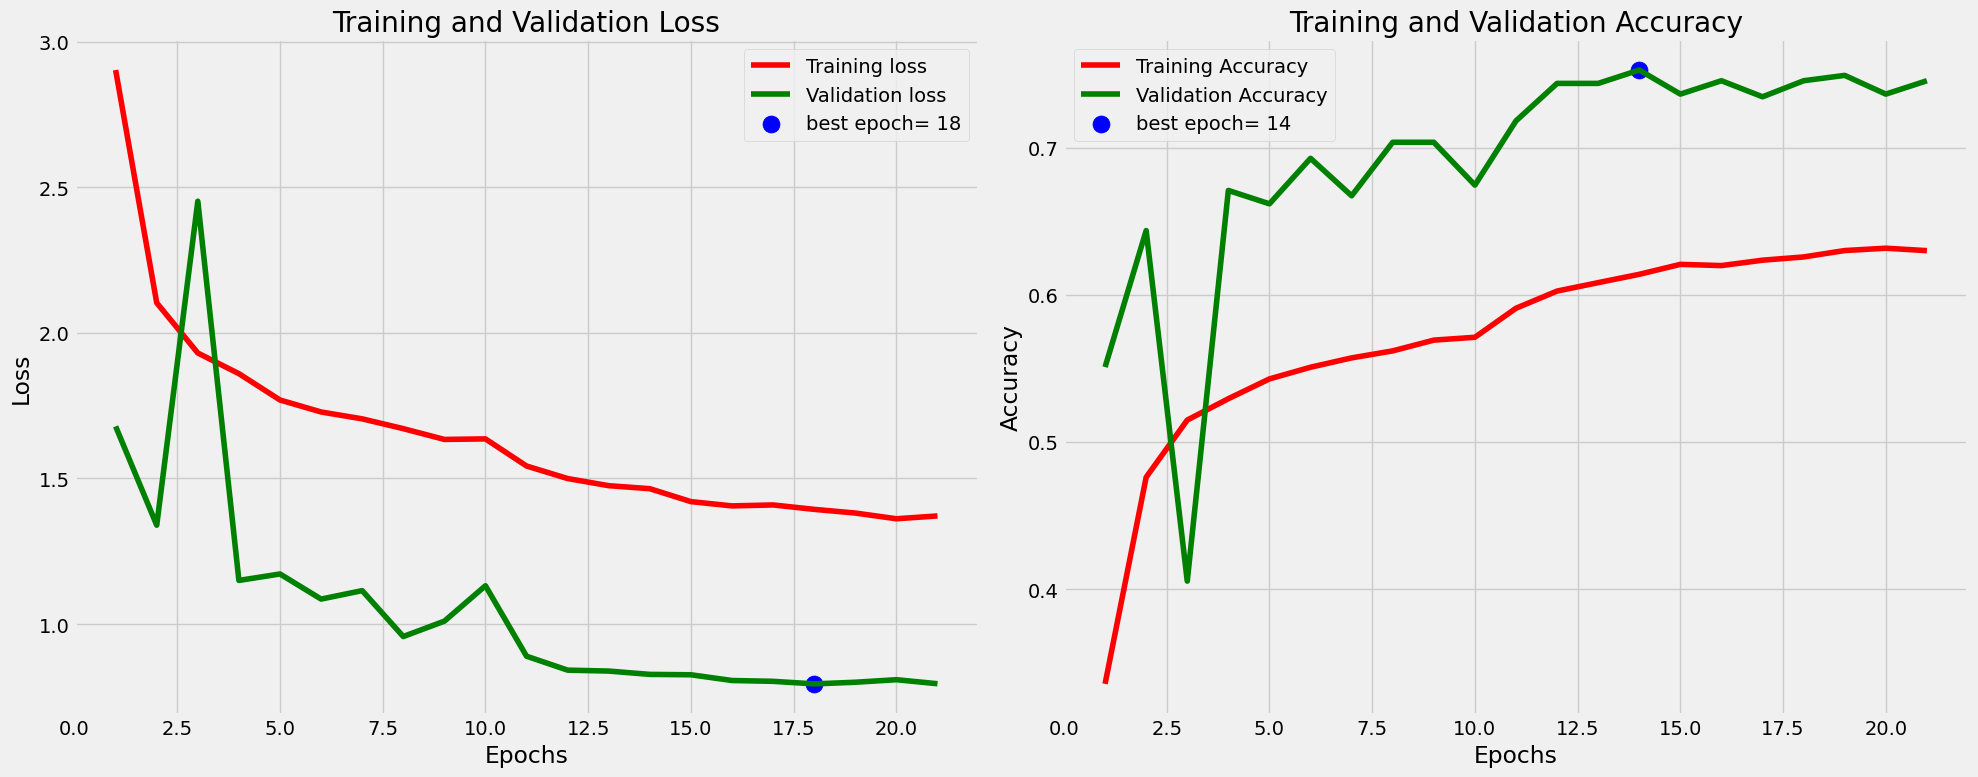

In [ ]:
# Define needed variables
tr_acc = history_inception_v3.history['accuracy']
tr_loss = history_inception_v3.history['loss']
val_acc = history_inception_v3.history['val_accuracy']
val_loss = history_inception_v3.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label='Training loss')
plt.plot(Epochs, val_loss, 'g', label='Validation loss')
plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s=150, c='blue', label=acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Model Evaluate

In [ ]:
results = model_inception_v3.evaluate(test_images_inception_v3, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.67505
Test Accuracy: 78.73%


F1 Score / Recall / Precision

In [ ]:
y_true = test_images_inception_v3.classes
y_pred = np.argmax(model_inception_v3.predict(test_images_inception_v3), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images_inception_v3.class_indices.keys()))

55/55 [==============================] - 3s 37ms/step
F1 Score: 0.7791068275159185
                       precision    recall  f1-score   support

           air hockey       0.60      0.60      0.60         5
      ampute football       0.83      1.00      0.91         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       0.44      0.80      0.57         5
        barell racing       0.50      1.00      0.67         5
             baseball       1.00      0.60      0.75         5
           basketball       0.60      0.60      0.60         5
       baton twirling       0.62      1.00      0.77         5
            bike polo       0.50      0.80      0.62         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.80      0.89         5
              bobsled       1.00  

#COMPARISON

In [ ]:
import pandas as pd

data = {
    'Model': ['ResNet50', 'VGG16', 'MobileNetV3 Large', 'EfficientNetB0', 'InceptionV3'],
    'Accuracy': ["89.64 %", "84 %", "93.82 %", "96.55 %", "78.73 %"],
    'F1 Score': [0.89 , 0.83, 0.93, 0.96, 0.77 ]
}

df = pd.DataFrame(data)

# Sort the DataFrame by 'Accuracy' in descending order
df = df.sort_values(by='Accuracy', ascending=False)

# Reset the index
df.reset_index(drop=True, inplace=True)

# Display the ranked table
print(df)


               Model Accuracy  F1 Score
0     EfficientNetB0  96.55 %      0.96
1  MobileNetV3 Large  93.82 %      0.93
2           ResNet50  89.64 %      0.89
3              VGG16     84 %      0.83
4        InceptionV3  78.73 %      0.77


# Best model is EfficientNet B0

Get Predictions

In [ ]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

55/55 [==============================] - 2s 37ms/step


Image Index  Test Labels     Test Classes  Prediction Labels  \
0            0          109  wingsuit flying                109   
1            1          109  wingsuit flying                109   
2            2          109  wingsuit flying                109   
3            3          109  wingsuit flying                109   
4            4          109  wingsuit flying                109   
5            5           99          trapeze                 73   
6            6           99          trapeze                 99   
7            7           99          trapeze                 99   

  Prediction Classes                                               Path  \
0    wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
1    wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
2    wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
3    wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
4    wingsuit flying  /content/drive/MyDrive/Thesis /data_thesis/tes...   
5      rock climbing  /content/drive/MyDrive/Thesis /data_thesis/tes...   
6            trapeze  /content/drive/MyDrive/Thesis /data_thesis/tes...   
7            trapeze  /content/drive/MyDrive/Thesis /data_thesis/tes...   

   Prediction Probability  
0                0.999951  
1                0.993248  
2                0.998955  
3                0.999286  
4                0.954929  
5                0.139841  
6                0.795767  
7                0.557454

Print the most confident errors

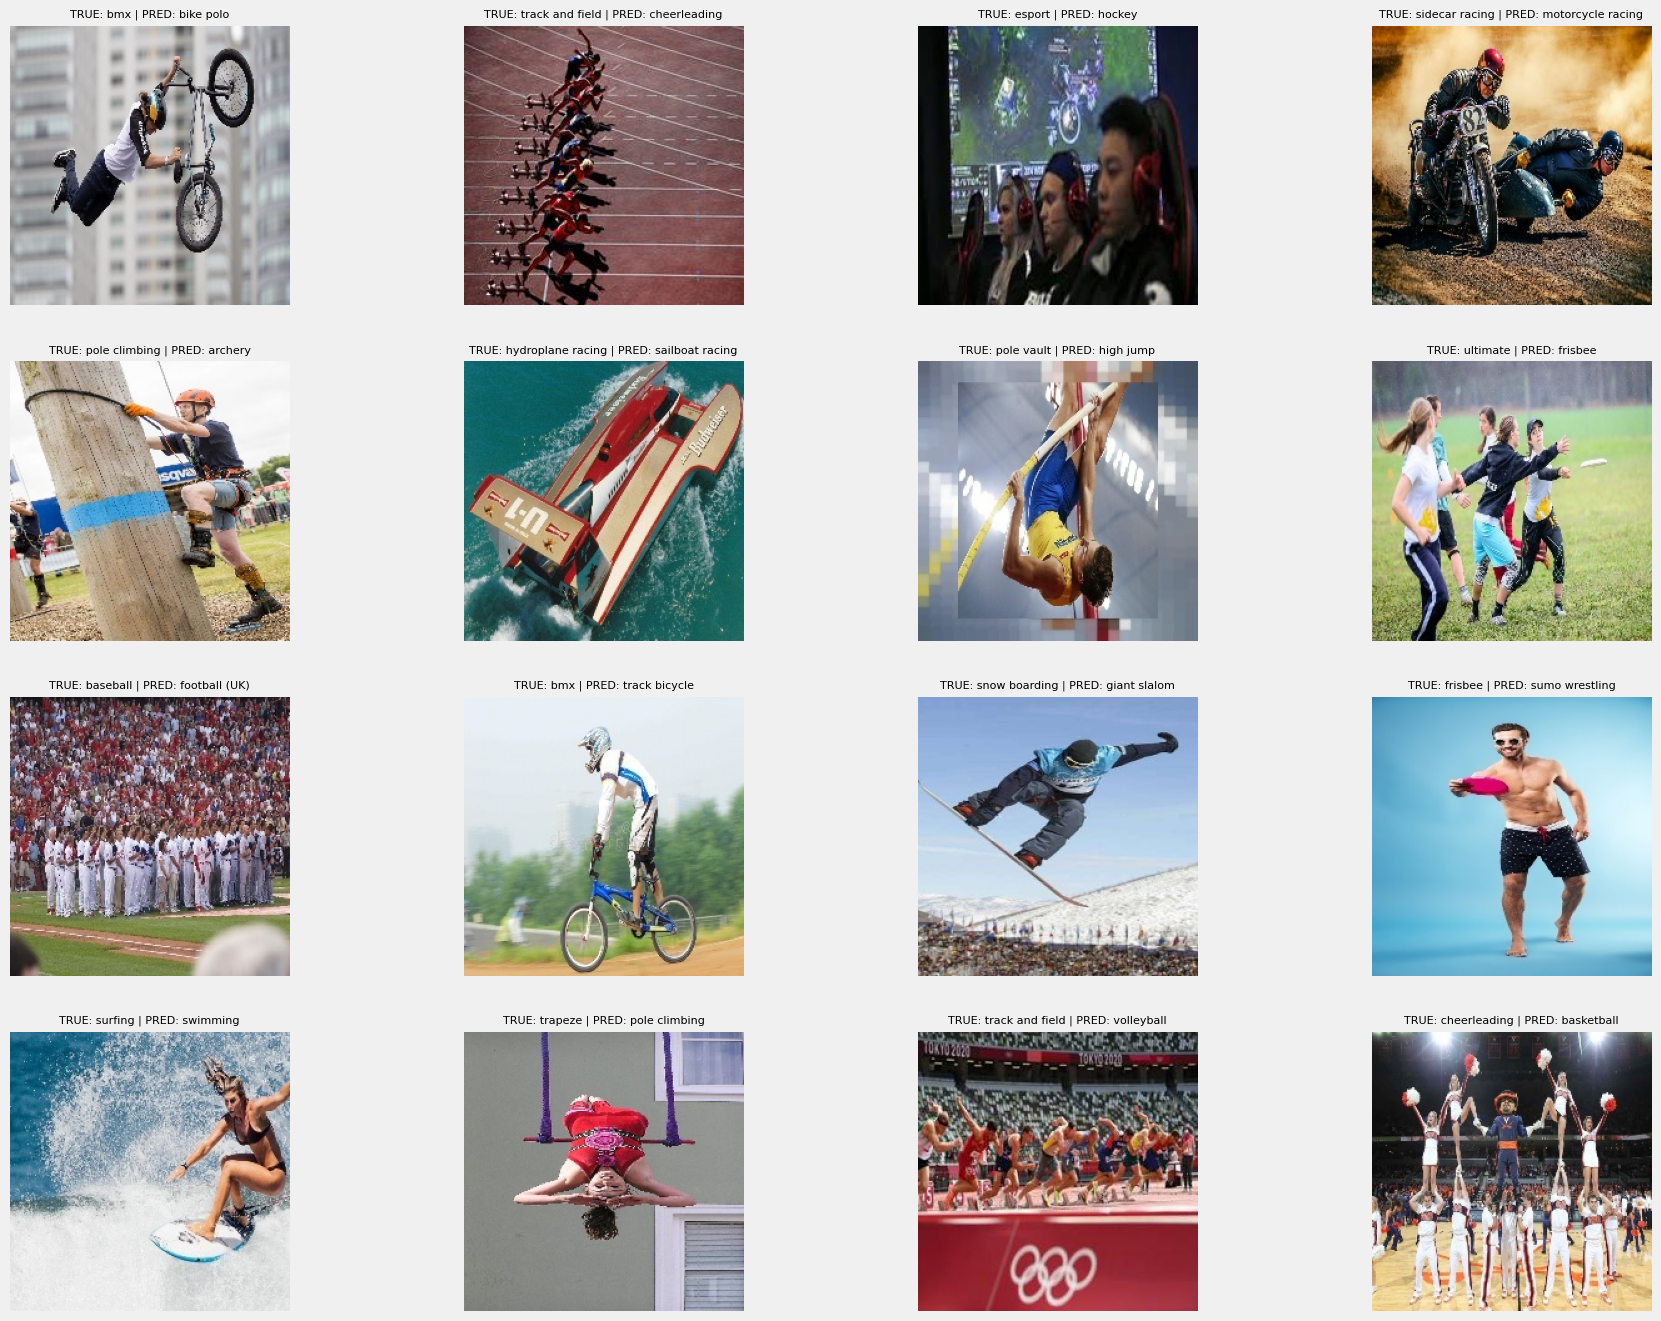

In [ ]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

Confusion Matrics and Classification Report

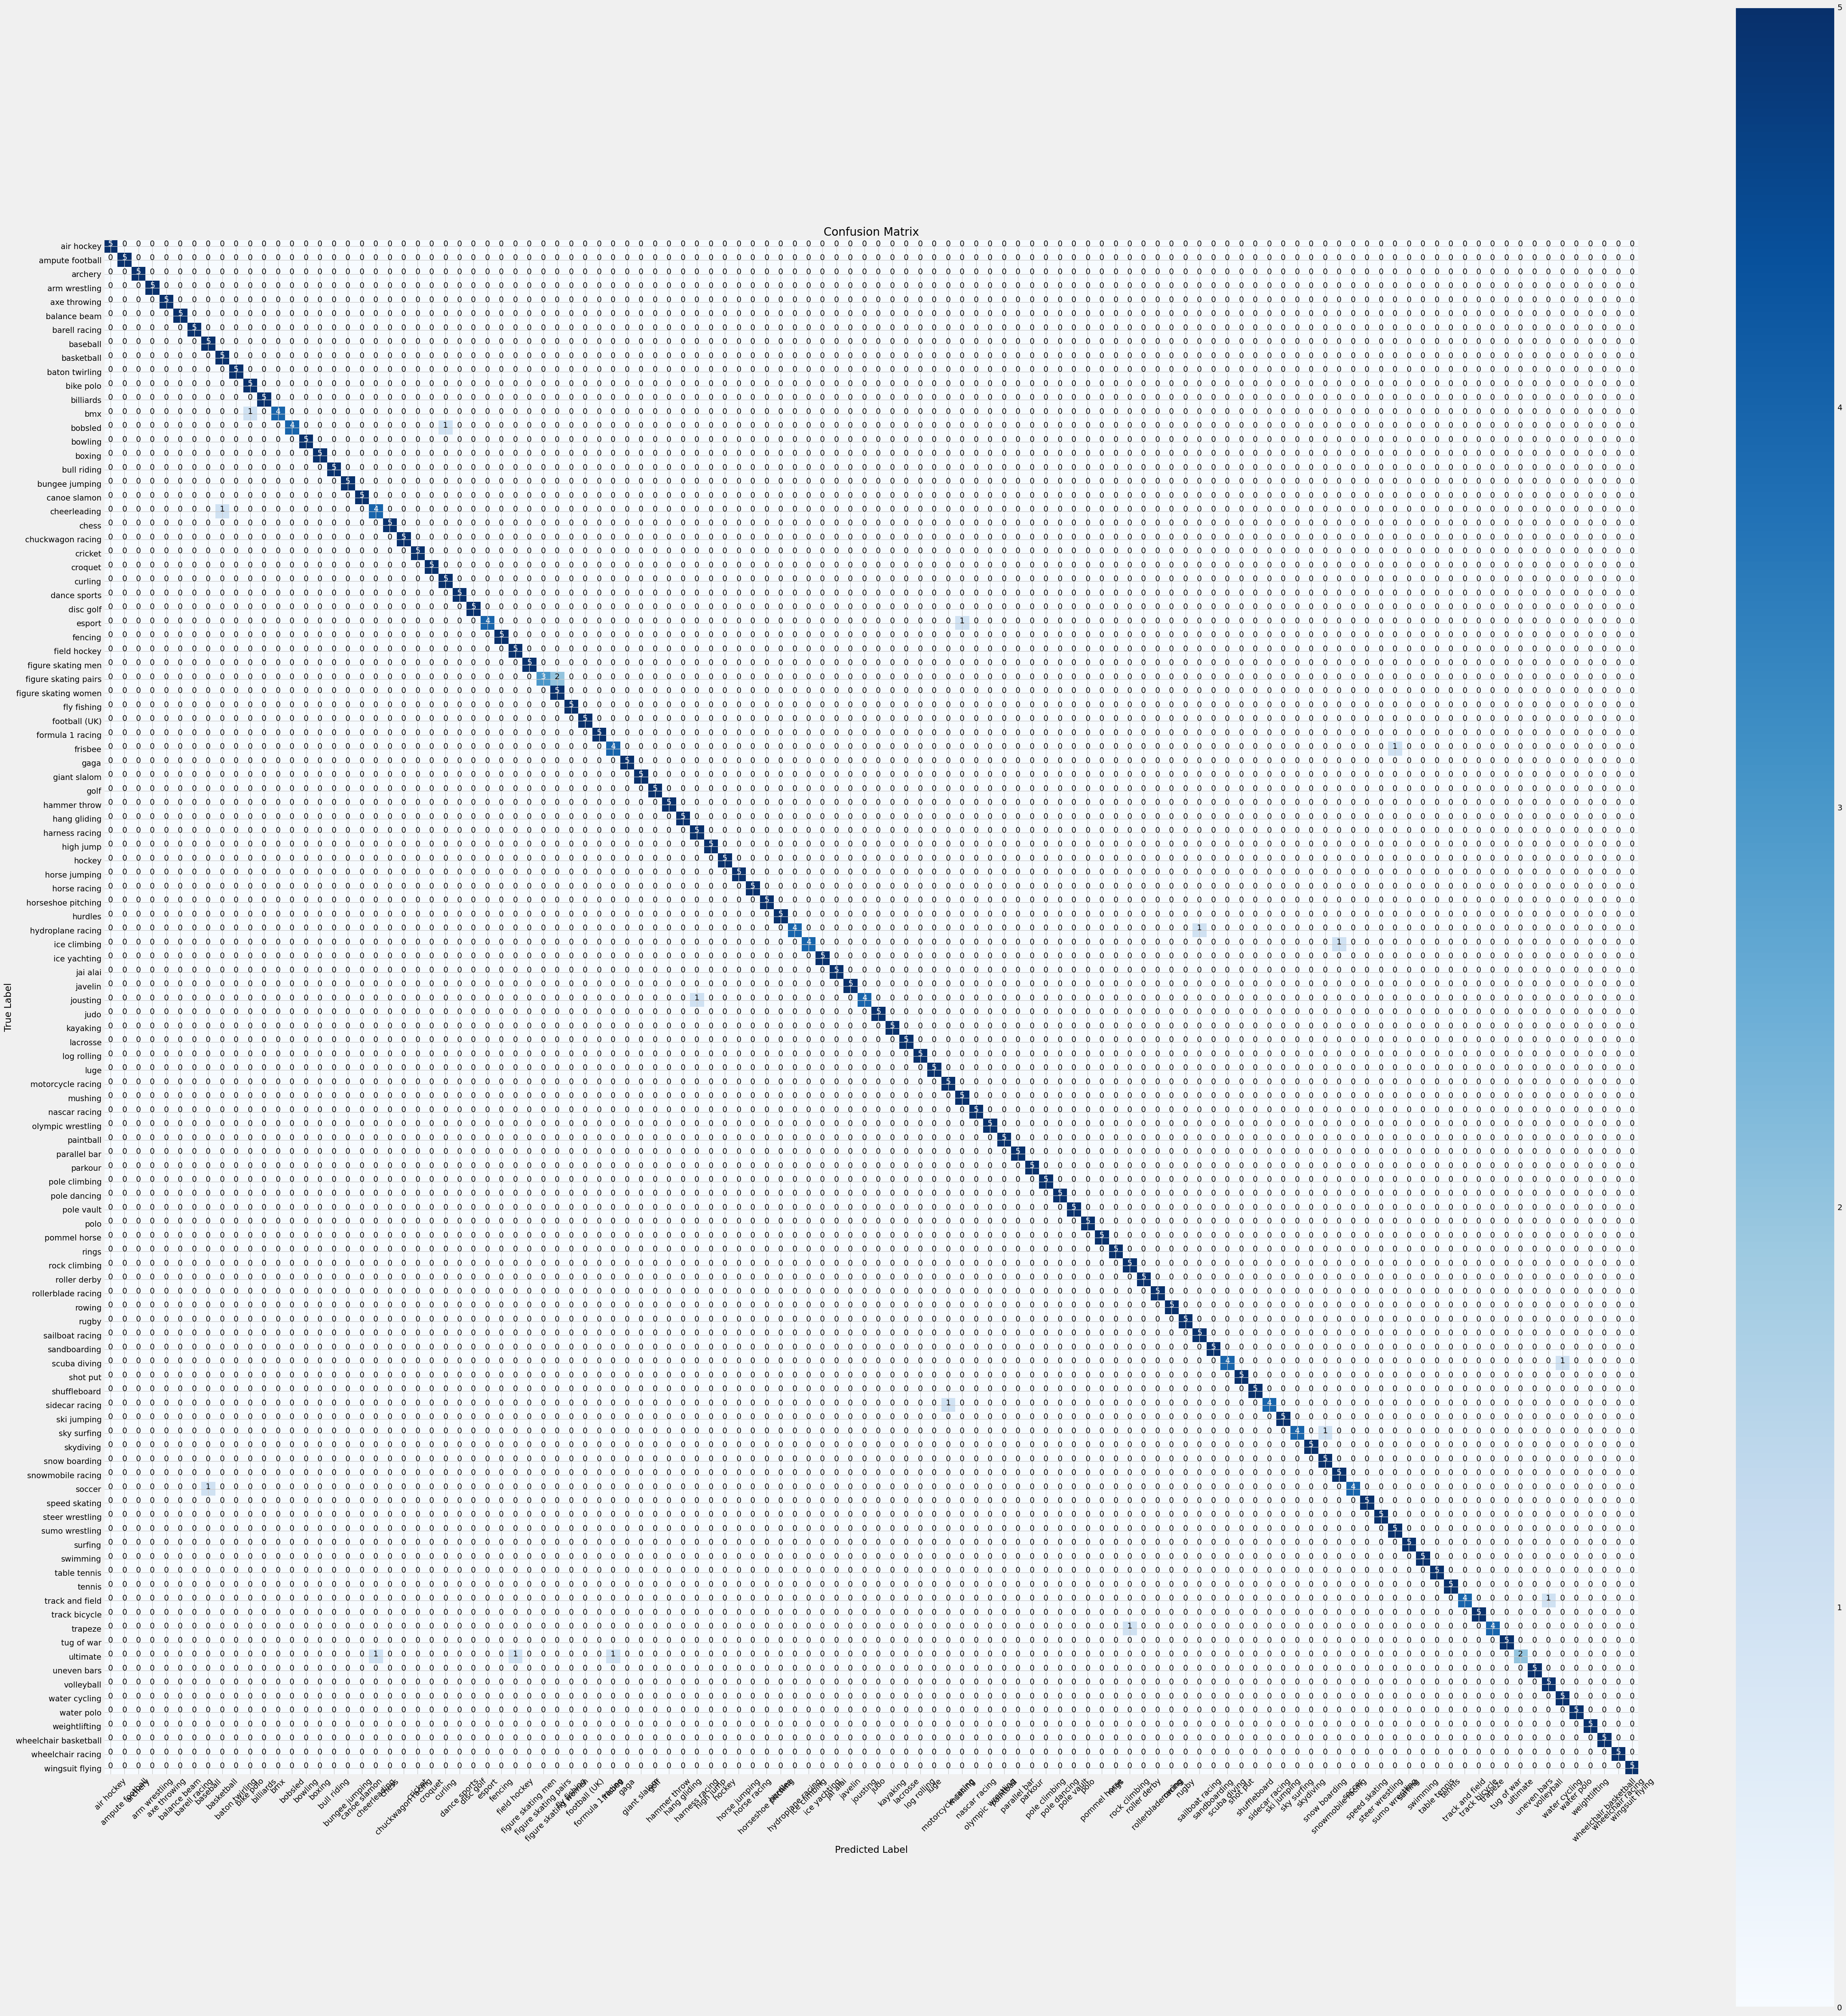

In [ ]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (50, 50))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()